In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from src.energies.alp_energy import ALPEnergy

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
n_particles = 22
n_spatial_dim = 3
dimensionality = n_spatial_dim * n_particles

energy = ALPEnergy(
    data_path="../../data/alanine/",
    pdb_filename="../../data/pdbs/A_capped.pdb",
    n_particles=n_particles,
    spatial_dim=n_spatial_dim,
    dimensionality=dimensionality,
    temperature=550,
    device=device,
    device_index="0",
    should_normalize=True,
    data_normalization_factor=0.1641
)
# energy_low = ALPEnergy(
#     data_path="../../data/alanine/",
#     pdb_filename="../../data/pdbs/A_capped.pdb",
#     n_particles=n_particles,
#     spatial_dim=n_spatial_dim,
#     dimensionality=dimensionality,
#     temperature=300,
#     device=device,
#     device_index="0",
# )

In [39]:
path = "/network/scratch/a/alexander.tong/energy_temp/logs/train/runs/2025-04-24_21-50-16/buffer_samples_temperature_600.000.pt"
path_energy = "/network/scratch/a/alexander.tong/energy_temp/logs/train/runs/2025-04-24_21-50-16/buffer_energies_temperature_600.000.pt"

generated_samples = torch.load(path, weights_only=True)
generated_samples = generated_samples.to(device)
saved_energies = torch.load(path_energy, weights_only=True)
true_samples = energy.sample_train_set(5000)

energy_generated_samples = energy(generated_samples)

print("Energy of generated samples: ", energy_generated_samples.mean().item())
print("Energy of generated samples (saved): ", saved_energies.mean().item())

Energy of generated samples:  -419.6290283203125
Energy of generated samples (saved):  -419.6290283203125


In [59]:
mask = energy_generated_samples > -200
generated_samples_masked = generated_samples[mask]

generated_samples_bad = generated_samples[~mask]

In [60]:
# make a nxn matrix of the interatomic distances upper triangualt value
interatomic_dist = energy.interatomic_dist(generated_samples)
interatomic_dist_true = energy.interatomic_dist(true_samples)
interatomic_dist_masked  = energy.interatomic_dist(generated_samples_masked)
interatomic_dist_bad = energy.interatomic_dist(generated_samples_bad)


int_dists = torch.zeros((generated_samples.shape[0], n_particles, n_particles)).to(device)
int_dists[:, torch.triu(torch.ones(n_particles, n_particles), diagonal=1) == 1] = interatomic_dist

int_dists_true = torch.zeros((true_samples.shape[0], n_particles, n_particles)).to(device)
int_dists_true[:, torch.triu(torch.ones(n_particles, n_particles), diagonal=1) == 1] = interatomic_dist_true


int_dists_masked = torch.zeros((generated_samples_masked.shape[0], n_particles, n_particles)).to(device)
int_dists_masked[:, torch.triu(torch.ones(n_particles, n_particles), diagonal=1) == 1] = interatomic_dist_masked

int_dists_bad = torch.zeros((generated_samples_bad.shape[0], n_particles, n_particles)).to(device)
int_dists_bad[:, torch.triu(torch.ones(n_particles, n_particles), diagonal=1) == 1] = interatomic_dist_bad


Text(0.5, 1.0, 'Interatomic distances (bad samples)')

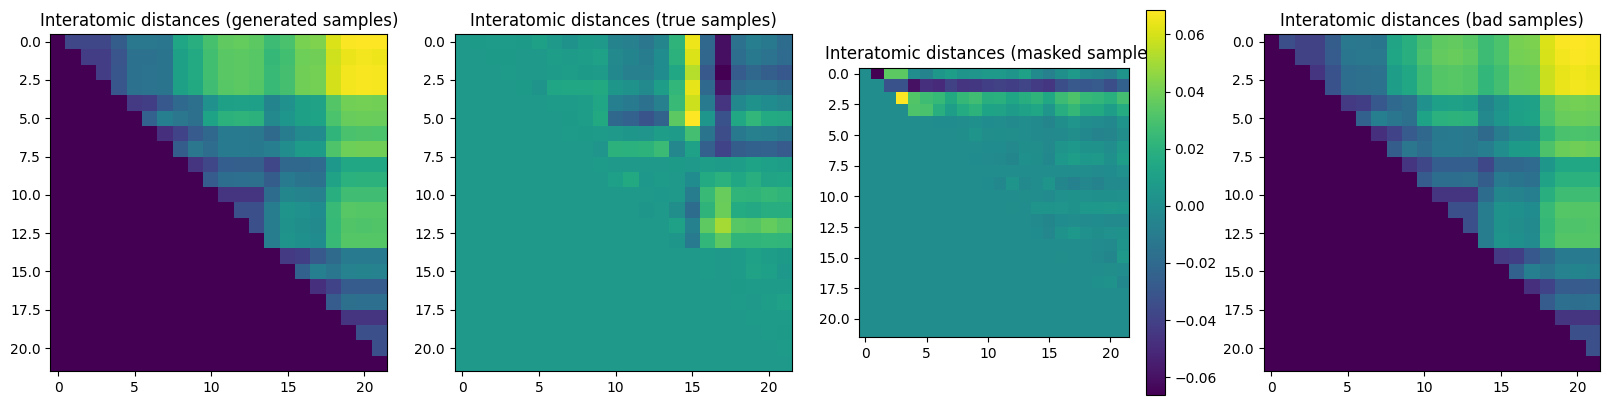

In [67]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(
    int_dists.mean(0).cpu().detach().numpy(),
    interpolation="nearest",
)
axs[0].set_title("Interatomic distances (generated samples)")


axs[1].imshow(
    int_dists_true.mean(0).cpu().detach().numpy() - int_dists_masked.mean(0).cpu().detach().numpy(),
    interpolation="nearest",
)

axs[1].set_title("Interatomic distances (true samples)")


axs[2].imshow(
    int_dists_masked.mean(0).cpu().detach().numpy() - int_dists_bad.mean(0).cpu().detach().numpy(),
    interpolation="nearest",
)
axs[2].set_title("Interatomic distances (masked samples)")
# put colorbar for axs[2]
fig.colorbar(axs[2].imshow(
    int_dists_masked.mean(0).cpu().detach().numpy() - int_dists_bad.mean(0).cpu().detach().numpy(),
    interpolation="nearest",
), ax=axs[2])

axs[3].imshow(
    int_dists_bad.mean(0).cpu().detach().numpy(),
    interpolation="nearest",
)
axs[3].set_title("Interatomic distances (bad samples)")








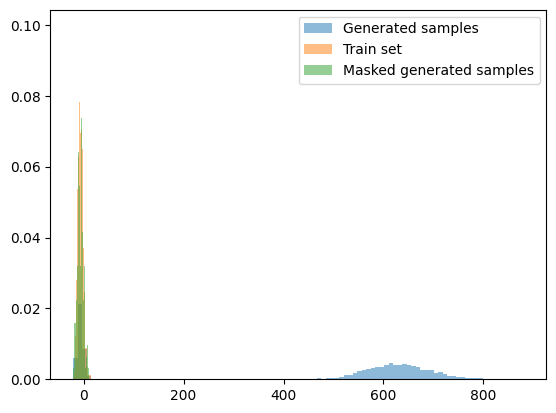

In [51]:
plt.hist(-energy_generated_samples.cpu().detach().numpy(), density=True, bins=100, alpha=0.5, label="Generated samples")
plt.hist(-energy(true_samples).cpu(), bins=200, density=True, alpha=0.5, label="Train set")
plt.hist(-energy(generated_samples_masked).cpu(), bins=200, density=True, alpha=0.5, label="Masked generated samples")
plt.legend()
plt.show()

In [ ]:
# high_temp_samples = torch.cat(
#     (energy.sample_train_set(10000), energy.sample_test_set(10000), energy.sample_val_set(10000)),
#     dim=0,
# )
# low_temp_samples = torch.cat(
#     (
#         energy_low.sample_train_set(10000),
#         energy_low.sample_test_set(10000),
#         energy_low.sample_val_set(10000),
#     ),
#     dim=0,
# )

In [ ]:
energy.plot_ramachandran(high_temp_samples.cpu())
energy_low.plot_ramachandran(low_temp_samples.cpu());

In [ ]:
high_temp_std

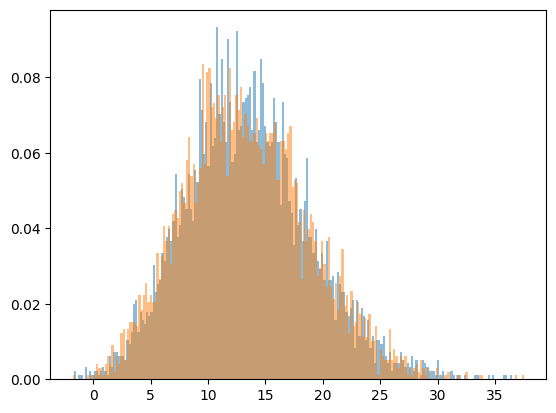

In [7]:
plt.hist(-energy(energy.sample_train_set(5000)).cpu(), bins=200, density=True, alpha=0.5)
plt.hist(-energy(energy.sample_test_set(5000)).cpu(), bins=200, density=True, alpha=0.5);

In [ ]:
import glob
from collections import defaultdict

import numpy as np

T = 1
noise_std = 0.2

samples = defaultdict(list)


temps = [300, 400, 450, 500, 550, 600, 1200]
for temp in temps:
    print(temp)
    path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/A_capped/A_capped_{temp}_100000.npz"

    try:
        samples = np.load(path)
        samples = samples["all_positions"]
        samples = samples.reshape(-1, dimensionality)
        print(f"Samples at {temp} has shape: {samples.shape}")
    except PermissionError:
        print(f"Permission error for file {path}")
        break

    idxs = np.random.permutation(samples.shape[0])
    train_idx = idxs[:10000]
    val_idx = idxs[10000:20000]
    test_idx = idxs[20000:30000]

    samples_train = samples[train_idx]
    samples_val = samples[val_idx]
    samples_test = samples[test_idx]

    # if directory does not exist, create it
    import os

    temp = temp.__float__()
    data_path = f"../../data/alanine/AL{n_particles}_temp_{temp}"
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    else:
        print(f"Directory {data_path} already exists. Overwriting data.")
    break
    # np.save(data_path + f"/train_split_AL{n_particles}-10000.npy", samples_train)
    # np.save(data_path + f"/val_split_AL{n_particles}-10000.npy", samples_val)
    # np.save(data_path + f"/test_split_AL{n_particles}-10000.npy", samples_test)
    print(f"Saved data for temperature {temp} to {data_path}")